## Decision Tree classifier on the E. coli dataset

**Name: Elise Rattigan**<br>
**Last modified:** August 2021<br>

This project is adapted from one of the assignments in my Machine Learning unit at university, for which I received a mark of 100%.

The purpose of this project was to use Decision Tree classification to explore the **E. Coli dataset** from *UCI Machine Learning*.  This dataset has 336 instances, each with a sequence name and 7 predictive attributes describing various scores. The goal for this project was to use a Decision Tree classifier to predict the class (protein localisation site) from the predictive attributes.

In this notebook, I will be using `GridSearch` cross-validation to find the best combination of hyperparameters, and then fitting the model to the training data. The Decision Tree will be evaluated and compared using the average F1-score and confusion matrix.

In [3]:
# Standard imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
%matplotlib inline

# For visualising decision trees
import graphviz
import pydotplus
import matplotlib.image as mpimg

## 1. Data Visualisation and Cleaning

The first step is to read in the data and output a pandas DataFrame. For this dataset, headers need to be hard-coded, as they are not included in the data file.

In [5]:
# List of column headers
header_list = ['Sequence Name', 'mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2', 'class']

# Specify directory where data is located
data_dir = os.path.join('data', 'ecoli.data')

# Import data and assign column headers
ecoli = pd.read_csv(data_dir, sep='\s+', names=header_list)

# Inspect first 5 lines of dataframe
ecoli.head()

,Sequence Name,mcg,gvh,lip,chg,aac,alm1,alm2,class
0,AAT_ECOLI,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,ACEA_ECOLI,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,ACEK_ECOLI,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,ACKA_ECOLI,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,ADI_ECOLI,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


In [6]:
# Overview of the dataframe
ecoli.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sequence Name  336 non-null    object 
 1   mcg            336 non-null    float64
 2   gvh            336 non-null    float64
 3   lip            336 non-null    float64
 4   chg            336 non-null    float64
 5   aac            336 non-null    float64
 6   alm1           336 non-null    float64
 7   alm2           336 non-null    float64
 8   class          336 non-null    object 
dtypes: float64(7), object(2)
memory usage: 23.8+ KB


The above output shows there are 336 observations in the dataset, and it has 9 attributes, as expected from the description of the dataset.  There are no missing values. The target attribute is `class`. All other attributes except 'Sequence Name' are numerical, and will be the predictor features.

We can look more closely at these features by visualising their distributions as histograms, as shown in the plot below.

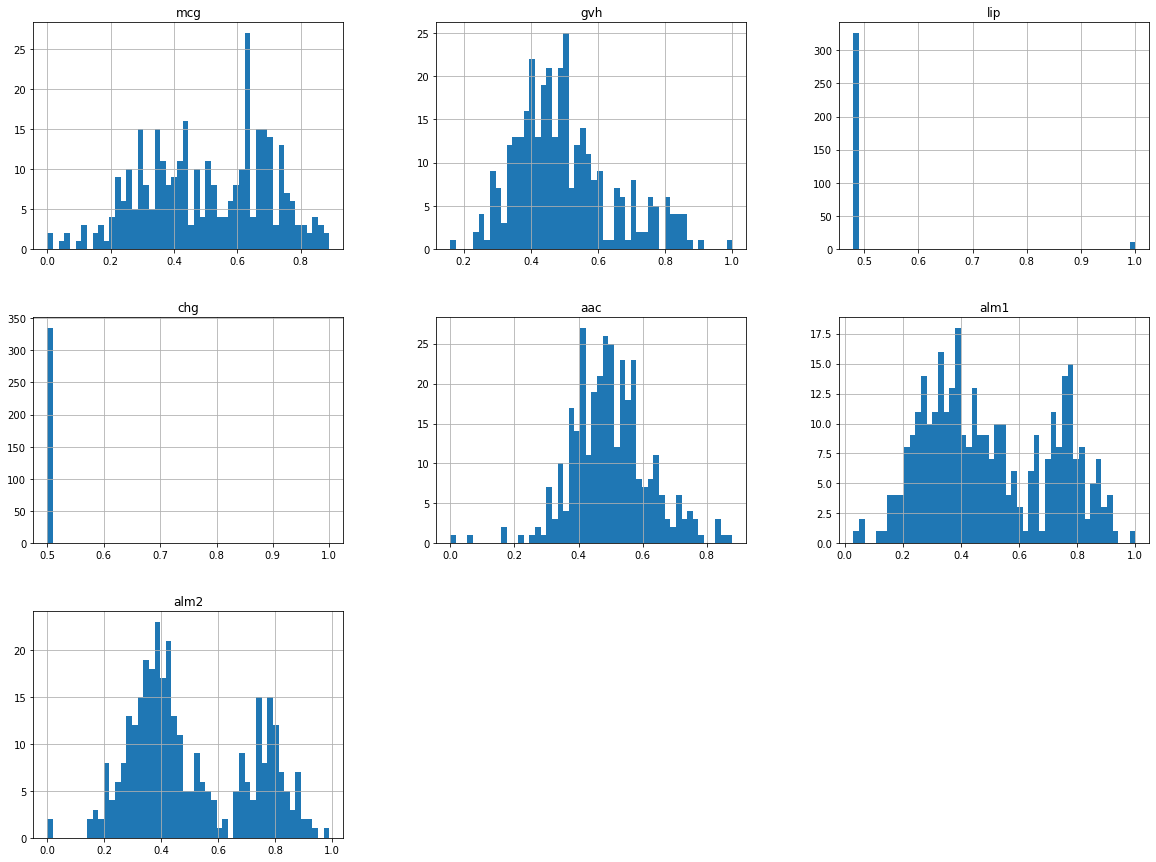

In [7]:
# Plot histograms of ecoli features
ecoli.hist(bins=50, figsize=(20,15))
plt.show()

We can see from these histograms that all the numerical features have quite different distributions. `chg` in particular only has one value, and `lip` has two, but not many observations for the second value. `alm1` and `alm2` appear to have bimodal distributions, while the rest appear to be Gaussian.

Another visualisation that provides useful information about the features in the dataset is a correlation matrix, shown below.

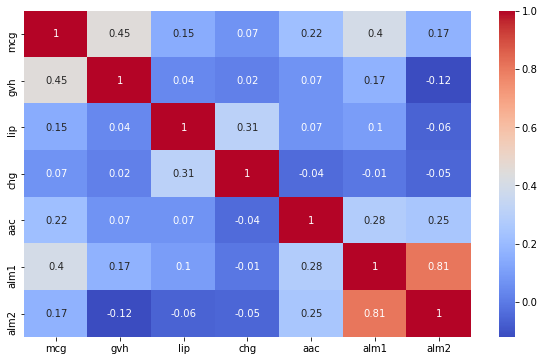

In [5]:
# Plot correlation matrix of numerical features
corr_matrix = ecoli.corr()
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(round(corr_matrix,2), annot=True, ax=ax, cmap="coolwarm");

The matrix shows the correlations between the numerical features in the dataset. As can be seen in the output above, most of the features are not highly correlated with any other features. The only obvious correlation seems to be between `alm1` and `alm2`. This makes sense, as these two features are highly related scores, according to the description of the dataset.

Next, there is some cleaning to do before Decision Tree classifiers can be trained on the data. Any classes with less than 10 instances need to be removed, as leaf nodes must contain at least 10 observations to be able to make predictions. The number of instances in each class is displayed below:

In [6]:
# Display the number of instances in each class
ecoli['class'].value_counts()

cp     143
im      77
pp      52
imU     35
om      20
omL      5
imL      2
imS      2
Name: class, dtype: int64

I will need to remove any instances belonging to the **omL**, **imS** and **imL** classes.

Additionally, the **'Sequence Name'** feature needs to be removed, because every single instance in this column is different. It therefore cannot be used as a predictor in the Decision Tree classifier. The code below demonstrates this, by showing that the number of unique values in the column is the same as the length of the column.

In [7]:
len1 = len(ecoli['Sequence Name'].unique())
len2 = len(ecoli['Sequence Name'])

print('There are {} unique values in the Sequence Name column, and the total length of the column is {}.'.format(len1, len2))

There are 336 unique values in the Sequence Name column, and the total length of the column is 336.


I have created the below function to carry out both cleaning operations: removing the classes with less than 10 instances, and removing 'Sequence Name' from the DataFrame.

In [8]:
# Function to clean data
def clean_data(df):
    
    # Drop rows belonging to specified classes
    index_names = df[(df['class'] == 'omL') | (df['class'] == 'imL') | (df['class'] == 'imS')].index
    df.drop(index_names, inplace = True)
    
    # Drop Sequence Name
    return df.drop(['Sequence Name'], axis = 1)

In [9]:
# Apply function to dataframe
ecoli_new = clean_data(ecoli)

In [10]:
# View the new dataframe
ecoli_new.head()

,mcg,gvh,lip,chg,aac,alm1,alm2,class
0,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


In [11]:
# Overview of the new dataframe
# ecoli_new.info()

In [12]:
# Class distributions for new dataframe
ecoli_new['class'].value_counts()

cp     143
im      77
pp      52
imU     35
om      20
Name: class, dtype: int64

## 2. Decision Tree Classifiers

Now that the data has been cleaned, I will train the Decision Tree classifier. For the purposes of this project, I will not be scaling the data, and will instead be training the model on the raw features. This is because Decision Tree classifiers are invariant to feature transformations, and in the original class assignment, my work showed that there was no difference between the results on the raw and scaled data.

Before training the classifier, I will first split the data into a training and test set. For this project, I decided to use a stratified test split due to the imbalance in the classes. This way, the distribution of classes is the same in both the training and test sets.

The code below uses the `train_test_split` function from Scikit-Learn to randomly split the data into a training set and a test set, with an 80/20 split and with stratify set to `True`. 

In [13]:
# First separate the target variable from the predictors
X = ecoli_new.drop('class', axis=1)

y = ecoli_new['class'].values

In [14]:
# Random seed for reproducibility
np.random.seed(42)

# Split into train and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y)

We can view the distribution of classes in each set using the code below, which counts the number of each unique value and returns it as a dictionary.

In [15]:
# Class distributions of training and test sets
unique, counts = np.unique(y_train, return_counts=True)
print('The class distribution of the test set is {}.'.format(dict(zip(unique, counts))))

The class distribution of the test set is {'cp': 114, 'im': 61, 'imU': 28, 'om': 16, 'pp': 42}.


In [16]:
# Class distribution of test set
unique, counts = np.unique(y_test, return_counts=True)
print('The class distribution of the test set is {}.'.format(dict(zip(unique, counts))))

The class distribution of the test set is {'cp': 29, 'im': 16, 'imU': 7, 'om': 4, 'pp': 10}.


We can see from the outputs above that training and test sets both have roughly the same proportions of each class.

Next, I can train the first Decision Tree classifier, using the raw (unscaled) training set.  I will use `GridSearchCV` with 3-fold cross-validation to find the best combination of hyperparameter values for the classifier, before fitting the model. I have chosen to use grid search on the following three hyperparameters:

* `max_depth`, which specifies the maximum tree depth. A large value leads to a large tree with many degrees of freedom, which may be too complex and overfit the data.
* `min_samples_leaf`, which specifies the minimum number of samples a leaf node must have. A small value may lead to too many nodes with too few samples, which could also cause overfitting.
* `max_features`, which specifies the maximum number of features evaluated for splitting at each node. Too many features may also cause overfitting.

I will investigate 3 different values for each of the hyperparameters.

In [17]:
# Create grid of parameters to search
params_grid = [{'max_depth': [2, 3, 4], 'min_samples_leaf': [10, 20, 30], 'max_features': [3, 5, 7]}]

In [18]:
# Train the decision tree on the training set

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Create DecisionTree object
tree_raw = DecisionTreeClassifier()

# Run GridSearchCV with grid of parameters, 3-fold cross-validation
grid_search_raw = GridSearchCV(tree_raw, params_grid, cv=3)
grid_search_raw.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid=[{'max_depth': [2, 3, 4], 'max_features': [3, 5, 7],
                          'min_samples_leaf': [10, 20, 30]}])

In [19]:
# Get the best combination of parameters
grid_search_raw.best_params_

{'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 10}

From the `GridSearchCV` results, it seems that the best hyperparameter values are a `max_depth` of 3, `max_features` of 7 (so all of the features), and minimum 10 samples per leaf.

I will use the best parameters from the `GridSearchCV` results to fit the Decision Tree classifier on the raw data.

In [20]:
# Get the final model
final_tree_raw = grid_search_raw.best_estimator_

We can also visualise the fitted model, using the `export_graphviz` function to output a graph definition file, and display this file as an image.

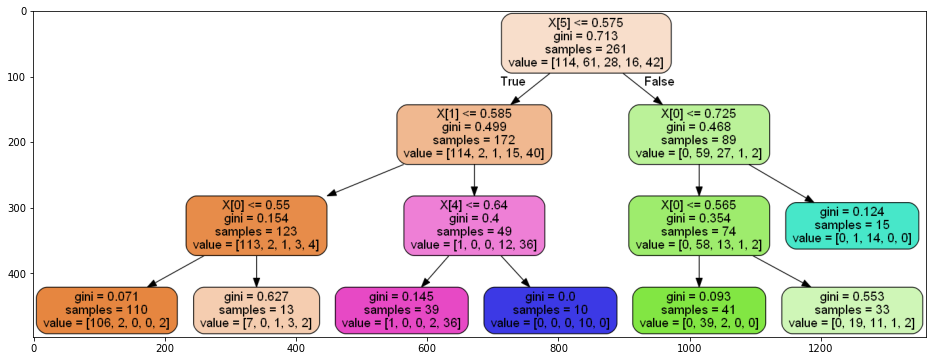

In [21]:
from sklearn.tree import export_graphviz

# Create dot data
dot_data = export_graphviz(
                final_tree_raw,
                out_file=None,
                rounded=True,
                filled=True
            )

# Write to PNG
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('tree_raw.png')

# Show as pyplot figure
plt.figure(figsize=(16,20))
imgplot = plt.imshow(mpimg.imread('tree_raw.png'))

plt.show()

Looking at the visualisation of the decision tree is a useful way of seeing the class splits at each point in the tree, and it can be used to make a class prediction for a new instance, by traversing the tree.  The 'gini' index gives a measure of the impurity at each node. We can see from this visualisation that the blue leaf node is "pure" with a gini index of 0, so all instances belong to the same class.  Other nodes are close to pure, but some are quite impure.

We can use this fitted tree model to make predictions on the test set, and see how well it performs on unseen data.  We can then evaluate its performance with a scoring metric such as F1 score. I will use cross-validation with three folds to evaluate the model, and get an output of three F1 scores.

Because there are multiple classes, the F1 score is generated for each class and then averaged. I will be using a `micro` average, which calculates a global average, across all the predictions for every class.

In [22]:
# Cross-validation with three folds to get average F1 score
from sklearn.model_selection import cross_val_score
scores = cross_val_score(final_tree_raw, X_test, y_test, cv=3, scoring="f1_micro")

print("Scores:", scores)
print("Mean of scores:", scores.mean())

Scores: [0.81818182 0.81818182 0.59090909]
Mean of scores: 0.7424242424242425


On two of the folds, this model achieved an F1 score over 80%, but only got 59% on the final fold. On average, this model's F1 score is 74%, which can definitely be improved upon.

We can look at the confusion matrix for these predictions to get more details on the correct classifications and misclassifications for each class.

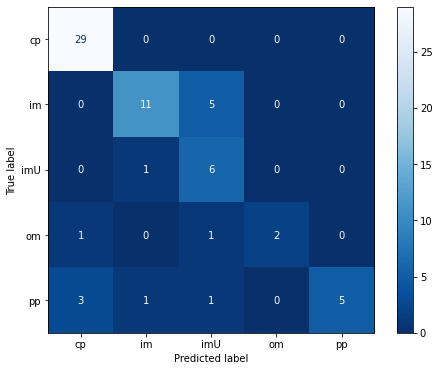

In [23]:
from sklearn.metrics import plot_confusion_matrix

# Define figure size
fig, ax = plt.subplots(figsize=(8, 6))

# Plot confusion matrix
plot_confusion_matrix(final_tree_raw, X_test, y_test,
                      cmap="Blues_r", ax=ax);

In the above confusion matrix, the diagonal elements represent the total correct values predicted per class. On most classes, this model doesn't appear to have done too badly. It seems to have the most trouble with the **im** class, predicting it incorrectly as **imU** 5/16 times. It also struggled with the **pp** class, predicting it incorrectly 5/10 times, 3 of these predicting it as **cp**.